# pyomo Battery Optimisation

In [1]:
from pathlib import Path
from datetime import timedelta
import timeit

import pyomo.environ as pyo
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
%load_ext jupyter_black

## NSW Energy Price Dec 2021

<AxesSubplot: xlabel='datetime'>

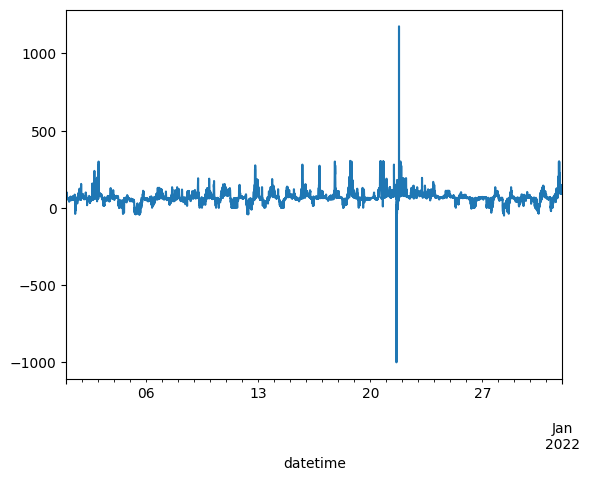

In [3]:
df = pd.read_parquet(Path.cwd().parent / "data")
df["SETTLEMENTDATE"] = pd.to_datetime(df["SETTLEMENTDATE"])
df = df.rename(columns={"SETTLEMENTDATE": "datetime", "RRP": "energy_price"})
df = df.query("INTERVENTION==0 and REGIONID=='NSW1'")
nsw_energy_price = df.set_index("datetime")["energy_price"]
nsw_energy_price.plot()

## Formulating the problem

Our mixed-integer linear program (MILP) formulation has one binary variable:

\begin{aligned}
\max_{t} \quad & \sum_{t=0}^T{\tau\lambda_t(p_t-q_t)}\\
\textrm{s.t.} \quad & u_t \in \{0,1\}    \\
& 0 \leq p_t \leq \bar{p}\\
& 0 \leq q_t \leq \bar{p} \\
& p_t - \bar{p}\left(1-u_t\right) \leq 0\\
& q_t - \bar{p}u_t \leq 0\\
& \underline{e} \leq e_t \leq \bar{e}    \\
& e_t-e_{t-1}- \left( q_t\eta_{charge}\tau\right)+\frac{p_t\tau}{\eta_{discharge}} = 0\\
& e_0 = 0.5\bar{e}\\
\end{aligned}

where:
- $\tau=\frac{1}{12} \textrm{hours}$
- $p_t$ corresponds to MW discharge at time $t$
- $q_t$ corresponds to MW charge at time $t$
- $u_t=1$ indicates charging, $u_t=0$ indicates discharging (*charge state*)
- $\bar{p}$ corresponds to the max power capacity in MW
- $\underline{e}$ and $\bar{e}$ corresponds to minimum and maximum state-of-charge limits, respectively
- $\lambda_t$ corresponds to the energy price in $/MWh at time $t$
- $\eta$ corresponds to efficiency (one term for charging and one term for discharging)

In [4]:
def create_pyomo_model(nsw_energy_price: pd.DataFrame, solver: str, verbose=True):
    power_cap = 30.0  # MW
    energy_cap = 30.0  # MWh
    soc_lower_limit = 0.1 * energy_cap  # MWh
    soc_upper_limit = 0.9 * energy_cap  # MWh
    charge_eff = 0.9  # unitless
    discharge_eff = 0.9  # unitless
    tau = 5.0 / 60.0  # minutes per hour
    # initial conditions
    initial_soc_mwh = 0.5 * energy_cap  # MWh

    m = pyo.ConcreteModel()

    # sets
    m.t = pyo.Set(initialize=range(len(nsw_energy_price)))

    # variables
    m.discharge_mw = pyo.Var(m.t, bounds=(0.0, power_cap))
    m.charge_mw = pyo.Var(m.t, bounds=(0.0, power_cap))
    m.charge_state = pyo.Var(m.t, domain=pyo.Binary)
    m.soc_mwh = pyo.Var(m.t, bounds=(soc_lower_limit, soc_upper_limit))

    # state of operation constraints
    def dischargeopRule(m, t):
        return m.discharge_mw[t] - power_cap * (1 - m.charge_state[t]) <= 0.0

    def chargeopRule(m, t):
        return m.charge_mw[t] - power_cap * m.charge_state[t] <= 0.0

    m.dischargeRule = pyo.Constraint(m.t, rule=dischargeopRule)
    m.chargeRule = pyo.Constraint(m.t, rule=chargeopRule)
    # intertemporal energy balance constraints
    def intertempSoCRule(m, t):
        if t > 0:
            return (
                m.soc_mwh[t]
                - m.soc_mwh[t - 1]
                - m.charge_mw[t] * charge_eff * tau
                + m.discharge_mw[t] / discharge_eff * tau
                == 0.0
            )
        return pyo.Constraint.Skip

    m.intertempSoCRule = pyo.Constraint(m.t, rule=intertempSoCRule)
    # initial SoC constraint
    def initialSoCRule(m):
        return m.soc_mwh[0] == 0.5 * energy_cap

    m.initialSoCRule = pyo.Constraint(rule=initialSoCRule)
    # objective - add negative sign as linopy only permits minimisation
    m.obj = pyo.Objective(
        expr=sum(
            nsw_energy_price[t] * tau * (m.discharge_mw[t] - m.charge_mw[t])
            for t in m.t
        ),
        sense=pyo.maximize,
    )
    if not verbose:
        pyo.SolverFactory(solver).solve(m, tee=False)
    else:
        pyo.SolverFactory(solver).solve(m).write()
    return m

In [5]:
model = create_pyomo_model(nsw_energy_price, "gurobi")

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x35713
  Lower bound: 171880.66124949063
  Upper bound: 171894.28923584093
  Number of objectives: 1
  Number of constraints: 26785
  Number of variables: 35713
  Number of binary variables: 8928
  Number of integer variables: 8928
  Number of continuous variables: 26785
  Number of nonzeros: 71422
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

In [6]:
cbc_model = create_pyomo_model(nsw_energy_price, "cbc")

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 171886.98462168
  Upper bound: 171886.98462168
  Number of objectives: 1
  Number of constraints: 26779
  Number of variables: 35706
  Number of binary variables: 8928
  Number of integer variables: 8928
  Number of nonzeros: 17682
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 5.83
  Wallclock time: 5.81
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  

## Benchmarking

In [7]:
import logging

logging.getLogger("pyomo.core").setLevel(logging.ERROR)
t_g = timeit.timeit(
    lambda: create_pyomo_model(nsw_energy_price, "gurobi", verbose=False), number=10
)
print(t_g / 10)

3.7915690093999728


In [8]:
t_cbc = timeit.timeit(
    lambda: create_pyomo_model(nsw_energy_price, "cbc", verbose=False), number=10
)
print(t_cbc / 10)

7.1988731140008895


## Solution

In [9]:
print("gurobi optimal solution cost {} found".format(model.obj()))
print("cbc optimal solution cost {} found".format(cbc_model.obj()))

gurobi optimal solution cost 171880.66124949028 found
cbc optimal solution cost 171886.98470044258 found


In [10]:
soln = pd.DataFrame(
    {
        "charge_mw": model.charge_mw[:](),
        "discharge_mw": model.discharge_mw[:](),
        "charge_state": model.charge_state[:](),
    },
    index=nsw_energy_price.index,
)

In [11]:
soln.loc[(soln["charge_mw"] > 0) & (soln["discharge_mw"] > 0)]

,charge_mw,discharge_mw,charge_state
datetime,,,


Text(0, 0.5, 'MW')

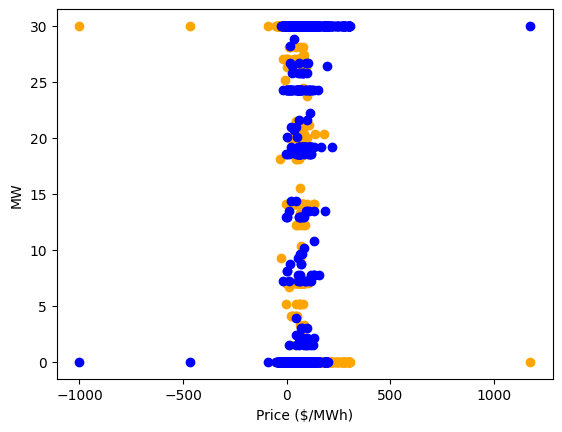

In [12]:
p = plt.scatter(nsw_energy_price, soln["charge_mw"], color="orange")
plt.scatter(nsw_energy_price, soln["discharge_mw"], color="blue")
plt.xlabel("Price ($/MWh)")
plt.ylabel("MW")

Text(0, 0.5, 'charge state')

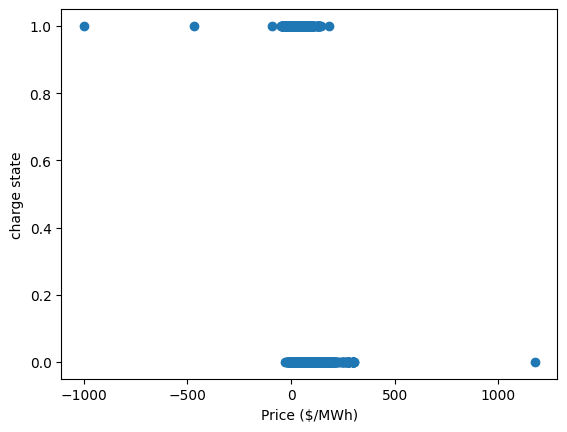

In [13]:
plt.scatter(nsw_energy_price, soln["charge_state"])
plt.xlabel("Price ($/MWh)")
plt.ylabel("charge state")